In [92]:
#import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import make_pipeline as sm_make_pipeline

from ast import literal_eval

import pickle

#load both datasets
user_1 = pd.read_csv('user_1.csv', converters={"artist_name": literal_eval}) # to convert strings back into list
user_2 = pd.read_csv('user_2.csv', converters={'artist_name': literal_eval})

### Preparing our data for modeling
Let's begin by concatenating the two datasets, creating an additional column that separates the two users, as well as identifies when both users listen to the same song (duplicates). 

In [13]:
user_1['user_group'] = 1
user_2['user_group'] = 0

spotify_df = pd.concat([user_1, user_2])
spotify_df.head()

,track_id,track_name,artist_name,artist_id,release_date,album_type,popularity,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,user_group
0,0sR0deixp6xTZ5Yx9g0pr0,Release Me,[Miette Hope],['4K61UysqQc1VRj8VsY76Qw'],2018-06-22,single,34,0.517,0.480,11,...,0,0.0425,0.6830,0.000000,0.0760,0.539,134.012,212236,4,1
1,0doiRAg2YNQvamY6oMPwkw,Dancing in the Street,[Stephen Day],['4cnFw4bkIWVGKUBsr93OS5'],2018-04-27,single,5,0.632,0.677,11,...,1,0.0911,0.2630,0.000010,0.0977,0.512,119.763,199027,4,1
2,0NuIfPuBhUAt4aA4HP0rUu,You Seemed so Happy,[The Japanese House],['3IunaFjvNKj98JW89JYv9u'],2019-03-01,album,53,0.519,0.888,11,...,1,0.1170,0.0406,0.000000,0.2270,0.416,149.938,162486,4,1
3,5EXD5rXJ4IVb8g4xSwT0fc,If You Were the Rain,[Stephen Day],['4cnFw4bkIWVGKUBsr93OS5'],2016-04-08,single,47,0.481,0.412,9,...,1,0.0401,0.6110,0.000059,0.0998,0.326,84.358,220588,4,1
4,68ViVsxqymVrKMnAbVsEhU,Talking Slow,[Dylan Jordan],['0vQwQkQbLxrapE7TG9o5SB'],2018-12-12,single,48,0.501,0.533,2,...,1,0.0379,0.2020,0.002060,0.1130,0.151,138.920,259640,4,1


In [14]:
#remove track info as they're insignificant to predict binary users / try keeping artist name
remove_lst = ['track_id', 'track_name', 'artist_id']
spotify_col = [col for col in spotify_df.columns.to_list() if col not in remove_lst]
spotify_df = spotify_df[spotify_col]
spotify_df.head()

,artist_name,release_date,album_type,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,user_group
0,[Miette Hope],2018-06-22,single,34,0.517,0.480,11,-7.944,0,0.0425,0.6830,0.000000,0.0760,0.539,134.012,212236,4,1
1,[Stephen Day],2018-04-27,single,5,0.632,0.677,11,-8.105,1,0.0911,0.2630,0.000010,0.0977,0.512,119.763,199027,4,1
2,[The Japanese House],2019-03-01,album,53,0.519,0.888,11,-6.232,1,0.1170,0.0406,0.000000,0.2270,0.416,149.938,162486,4,1
3,[Stephen Day],2016-04-08,single,47,0.481,0.412,9,-8.413,1,0.0401,0.6110,0.000059,0.0998,0.326,84.358,220588,4,1
4,[Dylan Jordan],2018-12-12,single,48,0.501,0.533,2,-10.110,1,0.0379,0.2020,0.002060,0.1130,0.151,138.920,259640,4,1


In [15]:
spotify_df.shape

(3949, 18)

#### Feature Engineering
To build a prediction model, data must be numeric ==> we should encode all categorical variables


In [16]:
#for the mode, we'll rename the values so that 1 is 'major' and 0 is 'minor' 
#--> this is so that we can one-hot-encode during preprocessing
spotify_df['mode'] = np.where(spotify_df['mode'] == 1, 'Major', "Minor")

In [17]:
#key, mode time_signatures are categorical values, so we'll transform them into strings to one-hot-encode
spotify_df['key'] = spotify_df['key'].astype(str)
spotify_df['time_signature'] = spotify_df['time_signature'].astype(str)

In [18]:
#we should figure out what to do with the release_date as we can't parse date-time objects into a model
#we could separate out year, month and date into individual columns 
spotify_df['release_date'] = pd.to_datetime(spotify_df['release_date'])
spotify_df['release_date_day'] = spotify_df['release_date'].dt.day
spotify_df['release_date_month'] = spotify_df['release_date'].dt.month
spotify_df['release_date_year'] = spotify_df['release_date'].dt.year

#we could also create a column to identify what week and day of the week a track was released
spotify_df['release_date_dayofweek'] = spotify_df['release_date'].dt.dayofweek
spotify_df['release_date_week'] = spotify_df['release_date'].dt.week

#drop the original release_date
spotify_df.drop('release_date', axis=1, inplace=True)

Release date would not usually come into consideration when we listen to music - especially what day of the week a track came out, etc. However, Spotify's playlist curation is greatly influenced by the day of the week a track is released. Specifically, there's a cut-point to when a track would be considered for editorial/algorithmic playlists; thus, it indirectly influences our music consumption habit.

Month, day, week and dayofweek are categorical variables in ordinal order

In [84]:
#categorical features
categorical_feat = ['artist_name', 'release_date_day', 'release_date_month', 'release_date_year',
                    'release_date_dayofweek', 'release_date_week', 'album_type', 'key', 'mode',
                    'time_signature']
numerical_feat = ['popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']


In [20]:
spotify_df.head()

,artist_name,album_type,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,...,valence,tempo,duration_ms,time_signature,user_group,release_date_day,release_date_month,release_date_year,release_date_dayofweek,release_date_week
0,[Miette Hope],single,34,0.517,0.480,11,-7.944,Minor,0.0425,0.6830,...,0.539,134.012,212236,4,1,22,6,2018,4,25
1,[Stephen Day],single,5,0.632,0.677,11,-8.105,Major,0.0911,0.2630,...,0.512,119.763,199027,4,1,27,4,2018,4,17
2,[The Japanese House],album,53,0.519,0.888,11,-6.232,Major,0.1170,0.0406,...,0.416,149.938,162486,4,1,1,3,2019,4,9
3,[Stephen Day],single,47,0.481,0.412,9,-8.413,Major,0.0401,0.6110,...,0.326,84.358,220588,4,1,8,4,2016,4,14
4,[Dylan Jordan],single,48,0.501,0.533,2,-10.110,Major,0.0379,0.2020,...,0.151,138.920,259640,4,1,12,12,2018,2,50


In [21]:
#before we start preprocessing the model, we should unstack the list of artists
spotify_df = spotify_df.explode('artist_name').reset_index(drop=True)
spotify_df['artist_name'].head()

0    Miette Hope
1           Jauz
2         Tisoki
3    Miette Hope
4           Jauz
Name: artist_name, dtype: object

In [22]:
spotify_df.shape

(11726, 22)

#### Train/Test Split and Preprocessing Machines

In [23]:
#prepare training and test sets with random state 2020 to maintain consistencies
X = spotify_df.drop('user_group', axis=1)
y = spotify_df['user_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2020)

In [24]:
print('Dataset Sizes:\nX_train:', X_train.shape, '\tX_test:', X_test.shape, '\ny_train: ', y_train.shape, '\ty_test:', y_test.shape)

Dataset Sizes:
X_train: (8794, 21) 	X_test: (2932, 21) 
y_train:  (8794,) 	y_test: (2932,)


In [25]:
#we can obverse the prevalence of our binary targets 
def calc_prevalence(y, var):
    total = [y_val for y_val in y if var == y_val]
    return len(total) / len(y)

user_1_prevalence = calc_prevalence(y_train.values, 1)
user_2_prevalence = 1 - user_1_prevalence

print('Train Dataset:')
print('Prevalence of User 1 in train: ', round(user_1_prevalence * 100, 2), '%', sep='')
print('Prevalence of User 2 in train: ', round(user_2_prevalence * 100, 2), '%', sep='')

print('\n\nTest Dataset:')
user_1_prevalence = calc_prevalence(y_test.values, 1)
user_2_prevalence = 1 - user_1_prevalence

print('Prevalence of User 1 in test: ', round(user_1_prevalence * 100, 2), '%', sep='')
print('Prevalence of User 2 in test: ', round(user_2_prevalence * 100, 2), '%', sep='')


Train Dataset:
Prevalence of User 1 in train: 56.55%
Prevalence of User 2 in train: 43.45%


Test Dataset:
Prevalence of User 1 in test: 58.59%
Prevalence of User 2 in test: 41.41%


Recognizing the weights of each sample size is crucial when we model, as we'll have to fine-tune it during grid-search.

In [26]:
#initialize preprocessing encoders
ore = OrdinalEncoder(cols=['key']) #ordinal values
ohe = OneHotEncoder() #artist_name, mode, time_signature, 
sc = StandardScaler()
pca = PCA(n_components=0.95)

#### Logistic Regression
As we're predicting on a binary variable (0, 1), we can use liblinear or saga as solvers - both allow L1 and L2 penalty. 
- Saga: Stochastic Average Gradient descent, extension of Sag that allows L1 Regularization.

- LibLinear: Library for Large Linear Classification. Uses a coordinate descent algorithm. Coordinate descent is based on minimizing a multivariate function by solving univariate optimization problems in a loop. In other words, it moves toward the minimum in one direction at a time. - currently Logistic Regression's default

#### Random Forest Classifier
Random forest is an ensemble supervised machine learning technique, bagging random feature selections and taking majority vote of scores of numerous decision trees. 

We'll test both models with a stratified K-Fold Cross Validation, and fine tune the method that produces the highest score.

#### Principle Component Analysis (PCA)
PCA is used when we want to reduce the number of variables and extract important features in each of our variables. As we're performing one-hot-encoding on the artist_name, this would reduce the size of our dataset before we run our estimator at the end of the pipeline.

### Stratified K-Fold Cross Validation

In [27]:
#initialize logistic regression and random forest classifier
logreg = LogisticRegression(max_iter=1000,
                           solver='liblinear',
                            multi_class='auto'
                            )
rfc = RandomForestClassifier(n_estimators=100,
                            min_samples_leaf=10
                            )

# create a pipeline with the preprocessing models
logreg_pipe = make_pipeline(ore, ohe, sc, logreg)
logreg_pipe_2 = make_pipeline(ore, ohe, sc, pca, logreg)
rfc_pipe = make_pipeline(ore, ohe, rfc)
rfc_pipe_2 = make_pipeline(ore, ohe, pca, rfc)

In [28]:
#stratify k-fold to maintain consistencies during cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)

#initalize cross validations, parsing k-fold
logreg_pipe_scores = cross_val_score(estimator=logreg_pipe, X=X_train, y=y_train, cv=kfold)
logreg_pipe_2_scores = cross_val_score(estimator=logreg_pipe_2, X=X_train, y=y_train, cv=kfold)
rfc_pipe_scores = cross_val_score(estimator=rfc_pipe, X=X_train, y=y_train, cv=kfold)
rfc_pipe_2_scores = cross_val_score(estimator=rfc_pipe_2, X=X_train, y=y_train, cv=kfold)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
numpy.linalg.LinAlgError: SVD did not converge

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
numpy.linalg.LinAlgError: SVD did not converge

  FitFailedWarning)


In [29]:
print('LogReg Pipeline Score:', np.mean(logreg_pipe_scores))
print('LogReg Pipeline (w/PCA) Score:', np.mean(logreg_pipe_2_scores))
print('RFC Pipeline Score:', np.mean(rfc_pipe_scores))
print('RFC Pipeline 2 (w/PCA) Score:', np.mean(rfc_pipe_2_scores))

LogReg Pipeline Score: 0.5937010440697961
LogReg Pipeline (w/PCA) Score: nan
RFC Pipeline Score: 0.6317948777649934
RFC Pipeline 2 (w/PCA) Score: 0.6713674061110065


The results of cross validation suggests that Random Forest with PCA (95% of features) performed the best. We can begin fine-tuning it with a Grid Search.

In [35]:
#set hyperparameters to test using grid search
#as the classes are uneven, we should adjust the binary target be inversely proportional to class frequencies
#we'll run a 95% PCA

#inialize the default pipeline
pipe = make_pipeline(ore, ohe, pca, rfc)

params = {
    'randomforestclassifier__n_estimators' : [50, 100, 250], 
    'randomforestclassifier__max_features' : [0.3, 0.4, 0.5, 0.6, 0.7],
    'randomforestclassifier__min_samples_leaf' : [5, 10, 15],
    'randomforestclassifier__class_weight': ['balanced'],
    'pca__n_components': [0.95]
}

#initialize the grid search 
grid_search = GridSearchCV(estimator=pipe, param_grid=params, cv=kfold)

In [36]:
#fit on training set
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2020, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('ordinalencoder',
                                        OrdinalEncoder(cols=['key'],
                                                       drop_invariant=False,
                                                       handle_missing='value',
                                                       handle_unknown='value',
                                                       mapping=None,
                                                       return_df=True,
                                                       verbose=0)),
                                       ('onehotencoder',
                                        OneHotEncoder(cols=None,
                                                      drop_invariant=False,
                                                      handle...
             ii

In [39]:
#find the best hyperparameters
grid_search.best_params_

{'pca__n_components': 0.95,
 'randomforestclassifier__class_weight': 'balanced',
 'randomforestclassifier__max_features': 0.6,
 'randomforestclassifier__min_samples_leaf': 5,
 'randomforestclassifier__n_estimators': 50}

In [40]:
#return every single permutation to find best features
grid_results = pd.DataFrame(grid_search.cv_results_)
grid_results.sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,param_randomforestclassifier__class_weight,param_randomforestclassifier__max_features,param_randomforestclassifier__min_samples_leaf,param_randomforestclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
27,13.387382,0.763517,0.611047,0.133031,0.95,balanced,0.6,5,50,"{'pca__n_components': 0.95, 'randomforestclass...",0.720864,0.711200,0.716316,0.704946,0.718430,0.714351,0.005680,1
37,15.053140,1.159683,0.550940,0.078844,0.95,balanced,0.7,5,100,"{'pca__n_components': 0.95, 'randomforestclass...",0.725412,0.702103,0.714042,0.711200,0.714448,0.713441,0.007460,2
29,17.615092,0.473499,0.554413,0.011844,0.95,balanced,0.6,5,250,"{'pca__n_components': 0.95, 'randomforestclass...",0.723707,0.699261,0.719159,0.707789,0.716155,0.713214,0.008697,3
36,13.515159,0.893635,0.605871,0.129652,0.95,balanced,0.7,5,50,"{'pca__n_components': 0.95, 'randomforestclass...",0.720864,0.705514,0.719159,0.703240,0.716155,0.712986,0.007225,4
38,16.936205,0.699404,0.737471,0.096676,0.95,balanced,0.7,5,250,"{'pca__n_components': 0.95, 'randomforestclass...",0.722001,0.698124,0.715748,0.711768,0.716724,0.712873,0.008064,5


The permutations of the grid_search suggests that a sample leaf of 5, with 50 trees, has the strongest influence on the performance of the model, with a test score above 0.7. We can set these identified parameters into the model.

In [41]:
#we'll update the pipeline and fit on the training set
pipe.steps[-1][1].set_params(
                            n_estimators=50,
                            class_weight='balanced',
                            max_features=0.6,
                            min_samples_leaf=5)
pipe.steps[-2][1].set_params(n_components=0.95)
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['key'], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[{'col': 'key', 'data_type': dtype('O'),
                                          'mapping': 7       1
5       2
3       3
6       4
0       5
9       6
11      7
2       8
1       9
10     10
8      11
4      12
NaN    -2
dtype: int64}],
                                return_df=True, verbose=0)),
                ('onehotencoder',
                 OneHotEncoder(cols=['artist_name', 'album_type', 'mode',
                                     'time_si...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=None,
                                        max_features=0.6, max_leaf_nodes=None,
        

#### Scoring -- Random Forest Classifer
Once we've fitted the training dataset, we can see how we did on the test set (unseen data).

Accuracy 0.7244201909959073 

Classification Report:               precision    recall  f1-score   support

           0       0.64      0.75      0.69      1214
           1       0.80      0.71      0.75      1718

    accuracy                           0.72      2932
   macro avg       0.72      0.73      0.72      2932
weighted avg       0.74      0.72      0.73      2932



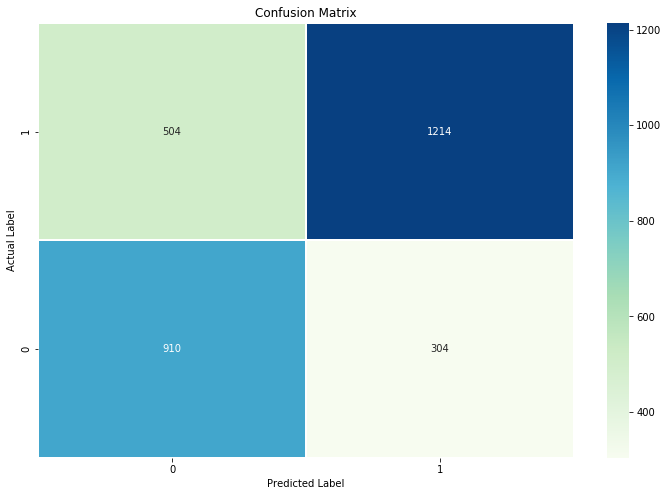

In [47]:
#Confusion Matrix
pipe_predict = pipe.predict(X_test)
c_matrix = confusion_matrix(y_test, pipe_predict)

plt.figure(figsize=(12, 8))
sns.heatmap(pd.DataFrame(c_matrix), annot=True, fmt='g',  cmap='GnBu', linewidths=1).set_ylim([0,2])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt. xlabel('Predicted Label');

#Evaluation Metrics
print('Accuracy', accuracy_score(y_test, pipe_predict), '\n')
print('Classification Report:', classification_report(y_test, pipe_predict))

In [48]:
#finally, score on test set
pipe.score(X_test, y_test)

0.7244201909959073

In [49]:
pipe.score(X_train, y_train)

0.8310211507846259

On unseen data, our model produced a score of 0.72, underfitting the score of the training set. The confusion matrix shows that there were a lot of 'mistakes' in the model - we should try and improve the score.

### Feature Engineering / Tuning the Model

The main reason why our accuracy was low is probably because there weren't a lot of features that differentiated the two user groups. Also, the imbalance in datasets, where User 2 accounted for 40% of the entire dataset, could be an issue - We could try to balance out the data so that the sample sizes are the same. 

Through some research, sklearn's resample and Imbalanced-Learn's SMOTE modules could be worth trying out.
https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

In [57]:
#Resample class to even out sizes
from sklearn.utils import resample

#combine training X and y
train_df = pd.concat([X_train, y_train], axis=1)

print('Initial training size:', train_df.shape)

user_1_train = train_df[train_df['user_group'] == 1]
user_2_train = train_df[train_df['user_group'] == 0]

#upsample the minority class --> User 2 group
user_2_upsampled = resample(user_2_train,
                           replace=True,
                           n_samples=len(user_1_train),
                           random_state=2020)
#undersample the majority class --> user 1
user_1_undersampled = resample(user_1_train,
                              replace=True,
                              n_samples=len(user_2_train),
                              random_state=2020)

#create new dataset with resampled dataset
upsampled_train = pd.concat([user_1_train, user_2_upsampled], sort=False)
upsampled_train.head()

Initial training size: (8794, 22)


,artist_name,album_type,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,...,valence,tempo,duration_ms,time_signature,release_date_day,release_date_month,release_date_year,release_date_dayofweek,release_date_week,user_group
9277,Alicia Keys,single,33,0.704,0.980,7,-3.248,Minor,0.1300,0.02110,...,0.277,128.050,235781,4,18,9,2015,4,38,1
7367,DVBBS,single,34,0.625,0.781,5,-3.840,Minor,0.0582,0.06050,...,0.439,159.968,244262,4,3,2,2017,4,5,1
2131,SIX60,single,66,0.397,0.524,3,-5.846,Major,0.1030,0.60700,...,0.343,175.562,218854,4,4,9,2019,2,36,1
5197,Cheat Codes,single,2,0.687,0.730,0,-5.906,Minor,0.0345,0.00313,...,0.333,128.028,183750,4,17,6,2016,4,24,1
5128,Lost Kings,single,61,0.597,0.682,9,-5.393,Minor,0.0874,0.00684,...,0.459,143.811,215565,4,7,10,2016,4,40,1


In [59]:
#check the resampled training size
print('Resampled training size:', upsampled_train.shape)

Resampled training size: (9946, 22)


In [63]:
#split the datasets and run it through the model
X_train_up = upsampled_train.drop('user_group', axis=1)
y_train_up = upsampled_train['user_group']

#prevalence of our targets?
def calc_prevalence(y):
    return sum(y) / len(y)

user_1_prevalence = calc_prevalence(y_train_up.values)
user_2_prevalence = 1 - user_1_prevalence 

print('Train Dataset:')
print('Prevalence of User 1 in train: ', round(user_1_prevalence * 100, 2), '%', sep='')
print('Prevalence of User 2 in train: ', round(user_2_prevalence * 100, 2), '%', sep='')

Train Dataset:
Prevalence of User 1 in train: 50.0%
Prevalence of User 2 in train: 50.0%


Now, our sample sizes are all equal.

In [65]:
#fit on the Random Forest Classifier 
pipe.fit(X_train_up, y_train_up)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['key'], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[{'col': 'key', 'data_type': dtype('O'),
                                          'mapping': 7       1
5       2
3       3
6       4
0       5
9       6
11      7
2       8
1       9
10     10
8      11
4      12
NaN    -2
dtype: int64}],
                                return_df=True, verbose=0)),
                ('onehotencoder',
                 OneHotEncoder(cols=['artist_name', 'album_type', 'mode',
                                     'time_si...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=None,
                                        max_features=0.6, max_leaf_nodes=None,
        

Accuracy 0.730218281036835
Classification Report:               precision    recall  f1-score   support

           0       0.66      0.73      0.69      1214
           1       0.79      0.73      0.76      1718

    accuracy                           0.73      2932
   macro avg       0.72      0.73      0.73      2932
weighted avg       0.74      0.73      0.73      2932



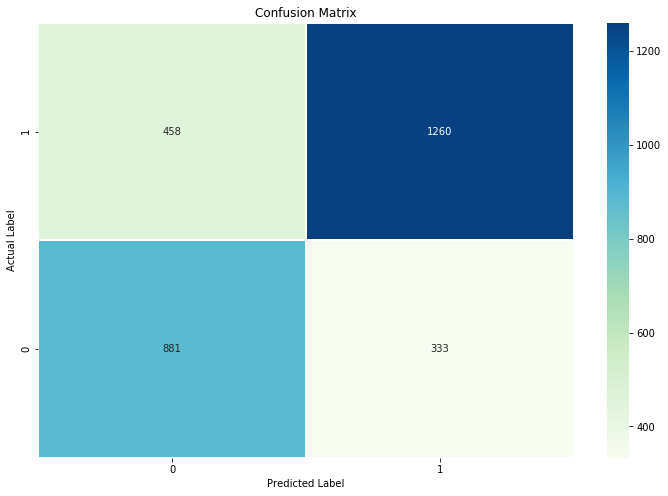

In [68]:
#Score
#Confusion Matrix
pipe_predict = pipe.predict(X_test)
c_matrix = confusion_matrix(y_test, pipe_predict)

plt.figure(figsize=(12, 8))
sns.heatmap(pd.DataFrame(c_matrix), annot=True, fmt='g', cmap='GnBu', linewidths=1).set_ylim([0,2])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt. xlabel('Predicted Label');

#Evaluation Metrics
print('Accuracy', accuracy_score(y_test, pipe_predict))
print('Classification Report:', classification_report(y_test, pipe_predict))

In [69]:
pipe.score(X_test, y_test)

0.730218281036835

Looks like our score improved slightly!

#### Synthetic Minority Oversampling Technique
We could also try resampling the data by creating synthetic data values using SMOTENC; Synthetic Minority Oversampling Technique for Nominal and Continous data. -- encodes both continual and categorical features

In [ ]:
{'pca__n_components': 0.95,
 'randomforestclassifier__class_weight': 'balanced',
 'randomforestclassifier__max_features': 0.6,
 'randomforestclassifier__min_samples_leaf': 5,
 'randomforestclassifier__n_estimators': 50}

In [121]:
#identify categorical features
categorical_indices = np.nonzero(spotify_df.columns.isin(categorical_feat))[0].tolist()
categorical_indices

[0, 1, 5, 7, 15, 17, 18, 19, 20, 21]

In [127]:
#initialize SMOTE
sm = SMOTENC(random_state=2020, categorical_features=categorical_indices)

#parse smote into the pipeline
rfc = RandomForestClassifier()
sm_pipe = sm_make_pipeline(ore, ohe, sc, sm, pca, rfc)

#we can test on the same parameters identified using grid search earlier
sm_pipe.steps[-1][1].set_params(class_weight='balanced',
                         max_features=0.6,
                         min_samples_leaf=5,
                         n_estimators=50)
sm_pipe.steps[-2][1].set_params(n_components=0.95)

#we can fit on the training set
sm_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['key'], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[{'col': 'key', 'data_type': dtype('O'),
                                          'mapping': 7       1
5       2
3       3
6       4
0       5
9       6
11      7
2       8
1       9
10     10
8      11
4      12
NaN    -2
dtype: int64}],
                                return_df=True, verbose=0)),
                ('onehotencoder',
                 OneHotEncoder(cols=['artist_name', 'album_type', 'mode',
                                     'time_si...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=None,
                                        max_features=0.6, max_leaf_nodes=None,
        

Accuracy 0.5985675306957708

Classification Report:               precision    recall  f1-score   support

           0       0.51      0.54      0.53      1214
           1       0.66      0.64      0.65      1718

    accuracy                           0.60      2932
   macro avg       0.59      0.59      0.59      2932
weighted avg       0.60      0.60      0.60      2932



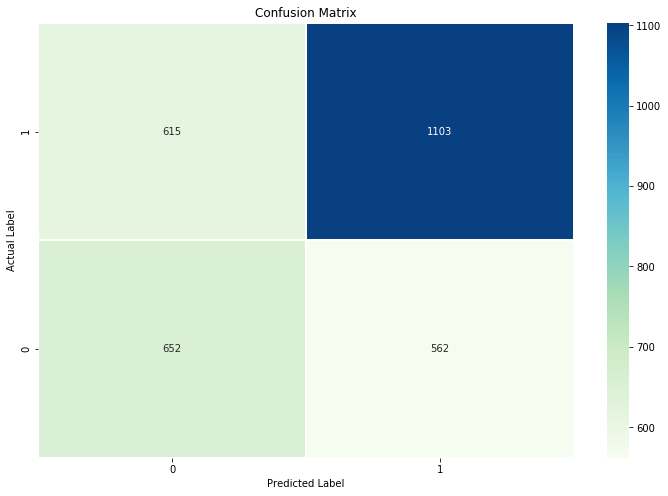

In [133]:
#Score
#Confusion Matrix
sm_pipe_predictions = sm_pipe.predict(X_test)
c_matrix = confusion_matrix(y_test, sm_pipe_predictions)

plt.figure(figsize=(12, 8))
sns.heatmap(pd.DataFrame(c_matrix), annot=True, fmt='g', cmap='GnBu', linewidths=1).set_ylim([0,2])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt. xlabel('Predicted Label');

#Evaluation Metrics
print('Accuracy', accuracy_score(y_test, sm_pipe_predictions))
print()
print('Classification Report:', classification_report(y_test, sm_pipe_predictions))

The result of fine-tuning it through oversampling the minority made a better improvement than using SMOTE. We could possibly run grid-search again to tune the hyper-parameters of SMOTENC. 

If we have more time, we could test out other models like SVM,and feature engineer additional columns like bringing in genres of tracks to further classify the user groups. Also, there were around 250 tracks that were in both playlists - this is probably why our accuracy was low. We should take this into consideration and either drop the data, or create a new variable to transform the model into multi-classification.

### Pickle 
We will pickle the pipeline to allow reproducability. 

In [134]:
with open('spotify.pkl', 'wb') as file:
    pickle.dump(pipe, file)